# PCA Transformation 探索与补全

这个notebook用于：
1. 探索已有的PCA结果
2. 补全缺失的StandardScaler参数
3. 测试变换功能


In [37]:
import numpy as np
import torch
import os
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# 设置路径（修改为你的实际路径）
pca_dir = 'experiments/pca_06102323'  # PCA结果目录
data_dir = 'cache_diffs/full_vs_doc2_03095340'  # 原始数据目录
flatten_mode = 'all'  # 必须与训练时一致！

print(f"PCA目录: {pca_dir}")
print(f"数据目录: {data_dir}")
print(f"Flatten模式: {flatten_mode}")


PCA目录: experiments/pca_06102323
数据目录: cache_diffs/full_vs_doc2_03095340
Flatten模式: all


## 步骤1：检查PCA目录现有文件


In [38]:
print("PCA目录内容：")
for f in sorted(os.listdir(pca_dir)):
    fpath = os.path.join(pca_dir, f)
    if os.path.isfile(fpath):
        size = os.path.getsize(fpath) / 1024 / 1024  # MB
        print(f"  {f:<30} {size:>10.2f} MB")

# 检查是否有StandardScaler参数
scaler_mean_file = os.path.join(pca_dir, 'scaler_mean.npy')
scaler_scale_file = os.path.join(pca_dir, 'scaler_scale.npy')
has_scaler = os.path.exists(scaler_mean_file) and os.path.exists(scaler_scale_file)

print(f"\nStandardScaler参数: {'✓ 存在' if has_scaler else '✗ 缺失（需要计算）'}")


PCA目录内容：
  explained_variance.txt               0.04 MB
  pc1_structure.png                    0.07 MB
  pc_layer_heatmap.png                 0.08 MB
  pc_scatter.png                       1.24 MB
  pc_statistics.png                    0.22 MB
  pc_weight_distributions.png          0.18 MB
  pca_components.npy               40000.00 MB
  pca_mean.npy                        40.00 MB
  pca_transformed.npy                  7.28 MB
  scaler_mean.npy                     40.00 MB
  scaler_scale.npy                    40.00 MB
  scree_plot.png                       0.23 MB

StandardScaler参数: ✓ 存在


## 步骤2：从原始数据计算StandardScaler参数


In [39]:
if not has_scaler:
    print("正在从原始数据计算StandardScaler参数...\\n")
    
    # GPU设置
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")
    if device.type == 'cuda':
        print(f"  GPU: {torch.cuda.get_device_name(device)}")
        print(f"  显存: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.1f} GB\\n")
    
    # 加载所有cache diff文件
    pt_files = sorted(glob(os.path.join(data_dir, "diff_*.pt")))
    print(f"找到 {len(pt_files)} 个文件")
    
    # 并行加载函数（返回torch tensor）
    def load_and_flatten(pt_file):
        data = torch.load(pt_file, map_location='cpu', weights_only=False)
        cache_diff = data['cache_diff']  # 保持为tensor
        if flatten_mode == 'all':
            return cache_diff.flatten()
        elif flatten_mode == 'layer_mean':
            return cache_diff.mean(dim=0).flatten()
        elif flatten_mode == 'state_mean':
            return cache_diff.mean(dim=2).flatten()
    
    # 并行加载（CPU多进程）
    from multiprocessing import Pool, cpu_count
    n_workers = min(cpu_count(), 8)
    print(f"使用 {n_workers} 个CPU进程并行加载\\n")
    
    with Pool(n_workers) as pool:
        all_data = list(tqdm(
            pool.imap(load_and_flatten, pt_files),
            total=len(pt_files),
            desc="CPU加载"
        ))
    
    # 转为tensor并移到GPU
    print("\\n将数据移至GPU...")
    X = torch.stack(all_data).to(device)
    print(f"数据矩阵形状: {X.shape}")
    print(f"占用显存: {X.element_size() * X.nelement() / 1024**3:.2f} GB")
    
    # 在GPU上计算统计量
    print("\\nGPU计算统计量...")
    scaler_mean = X.mean(dim=0)
    scaler_scale = X.std(dim=0)
    scaler_scale[scaler_scale == 0] = 1.0
    
    # 移回CPU并转为numpy
    scaler_mean = scaler_mean.cpu().numpy()
    scaler_scale = scaler_scale.cpu().numpy()
    
    print(f"\\nScaler统计：")
    print(f"  Mean - range: [{scaler_mean.min():.6f}, {scaler_mean.max():.6f}]")
    print(f"  Scale - range: [{scaler_scale.min():.6f}, {scaler_scale.max():.6f}]")
    
    # 保存
    np.save(scaler_mean_file, scaler_mean)
    np.save(scaler_scale_file, scaler_scale)
    print(f"\\n✓ 已保存到:")
    print(f"  {scaler_mean_file}")
    print(f"  {scaler_scale_file}")
    
    # 清理GPU显存
    del X, scaler_mean, scaler_scale
    torch.cuda.empty_cache()
else:
    print("StandardScaler参数已存在，跳过计算")


StandardScaler参数已存在，跳过计算


## 步骤3：加载所有变换参数并测试


In [40]:
# 加载变换参数
pca_components = np.load(os.path.join(pca_dir, 'pca_components.npy'))
scaler_mean = np.load(os.path.join(pca_dir, 'scaler_mean.npy'))
scaler_scale = np.load(os.path.join(pca_dir, 'scaler_scale.npy'))

print("✓ 所有参数已加载：")
print(f"  PCA components: {pca_components.shape}")
print(f"  Scaler mean: {scaler_mean.shape}")
print(f"  Scaler scale: {scaler_scale.shape}")

# 定义变换函数
def transform_cache_diff(cache_diff):
    """变换一个cache difference到PCA空间"""
    # Step 1: 展平
    if flatten_mode == 'all':
        x = cache_diff.flatten()
    elif flatten_mode == 'layer_mean':
        x = cache_diff.mean(axis=0).flatten()
    elif flatten_mode == 'state_mean':
        x = cache_diff.mean(axis=2).flatten()
    
    # Step 2: 标准化（已经做了中心化，不需要额外的 PCA mean）
    x = (x - scaler_mean) / scaler_scale
    
    # Step 3: 投影到主成分
    x_pca = x @ pca_components.T
    
    return x_pca

print("\\n✓ 变换函数已定义")


✓ 所有参数已加载：
  PCA components: (1000, 5242880)
  Scaler mean: (5242880,)
  Scaler scale: (5242880,)
\n✓ 变换函数已定义


## 步骤4：测试变换功能


In [41]:
# 测试：随机选择一个文件
test_file = glob(os.path.join(data_dir, "diff_*.pt"))[0]
print(f"测试文件: {os.path.basename(test_file)}")

# 加载并变换
data = torch.load(test_file, map_location='cpu', weights_only=False)
cache_diff = data['cache_diff'].numpy()
print(f"原始形状: {cache_diff.shape}")

x_pca = transform_cache_diff(cache_diff)
print(f"变换后形状: {x_pca.shape}")
print(f"\\n统计:")
print(f"  Min: {x_pca.min():.6f}")
print(f"  Max: {x_pca.max():.6f}")
print(f"  Mean: {x_pca.mean():.6f}")
print(f"  Std: {x_pca.std():.6f}")


测试文件: diff_0262_id_5ae6021a5542996de7b71aea.pt
原始形状: (64, 5120, 16)
变换后形状: (1000,)
\n统计:
  Min: -324.231872
  Max: 371.045381
  Mean: -4.817462
  Std: 68.415508


## 步骤5：验证 - 与保存的结果对比


In [42]:
# 加载训练时保存的变换结果
pca_transformed_saved = np.load(os.path.join(pca_dir, 'pca_transformed.npy'))
print(f"保存的变换结果: {pca_transformed_saved.shape}")

# 重新变换前10个样本进行验证
pt_files = sorted(glob(os.path.join(data_dir, "diff_*.pt")))
transformed_new = []

for pt_file in tqdm(pt_files[:10], desc="验证前10个"):
    data = torch.load(pt_file, map_location='cpu', weights_only=False)
    cache_diff = data['cache_diff'].numpy()
    x_pca = transform_cache_diff(cache_diff)
    transformed_new.append(x_pca)

transformed_new = np.array(transformed_new)
print(f"新计算的变换结果: {transformed_new.shape}")

# 对比：只比较公共的成分数量
n_components = min(transformed_new.shape[1], pca_transformed_saved.shape[1])
print(f"\\n对比前 {n_components} 个成分...")

diff = np.abs(transformed_new[:, :n_components] - pca_transformed_saved[:10, :n_components])
print(f"\\n差异统计：")
print(f"  最大差异: {diff.max():.10f}")
print(f"  平均差异: {diff.mean():.10f}")
print(f"  中位数差异: {np.median(diff):.10f}")

if diff.max() < 1e-3:  # 放宽一点，因为去掉了pca_mean
    print("\\n✓ 验证通过！变换结果基本一致！")
elif diff.max() < 0.1:
    print("\\n⚠ 有小差异，但在可接受范围内")
    print("  （可能因为省略了pca_mean，但影响很小）")
else:
    print("\\n✗ 存在较大差异，请检查：")
    print("  1. flatten_mode 是否正确")
    print("  2. 是否使用了正确的PCA结果目录")


保存的变换结果: (1000, 954)


验证前10个: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

新计算的变换结果: (10, 1000)
\n对比前 954 个成分...
\n差异统计：
  最大差异: 0.0028004898
  平均差异: 0.0003828923
  中位数差异: 0.0003155948
\n⚠ 有小差异，但在可接受范围内
  （可能因为省略了pca_mean，但影响很小）


## Step 6: Visualize Transformation Matrix

PCA transformation matrix shape: `(n_components, 5242880)`

We will visualize:
1. **Statistical distributions of PCs**: Weight distributions of each principal component
2. **Reshaped heatmaps**: Visualize after reshaping features to `(layers, d_inner, d_state)`
3. **Comparison of top PCs**: See which features different PCs focus on


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Preparing visualization...")
print(f"PCA components shape: {pca_components.shape}")
print(f"Reshaping features to: [64 layers, 5120 d_inner, 16 d_state] = {64*5120*16}")

# Original cache_diff shape
n_layers = 64
d_inner = 5120
d_state = 16


Preparing visualization...
PCA components shape: (1000, 5242880)
Reshaping features to: [64 layers, 5120 d_inner, 16 d_state] = 5242880


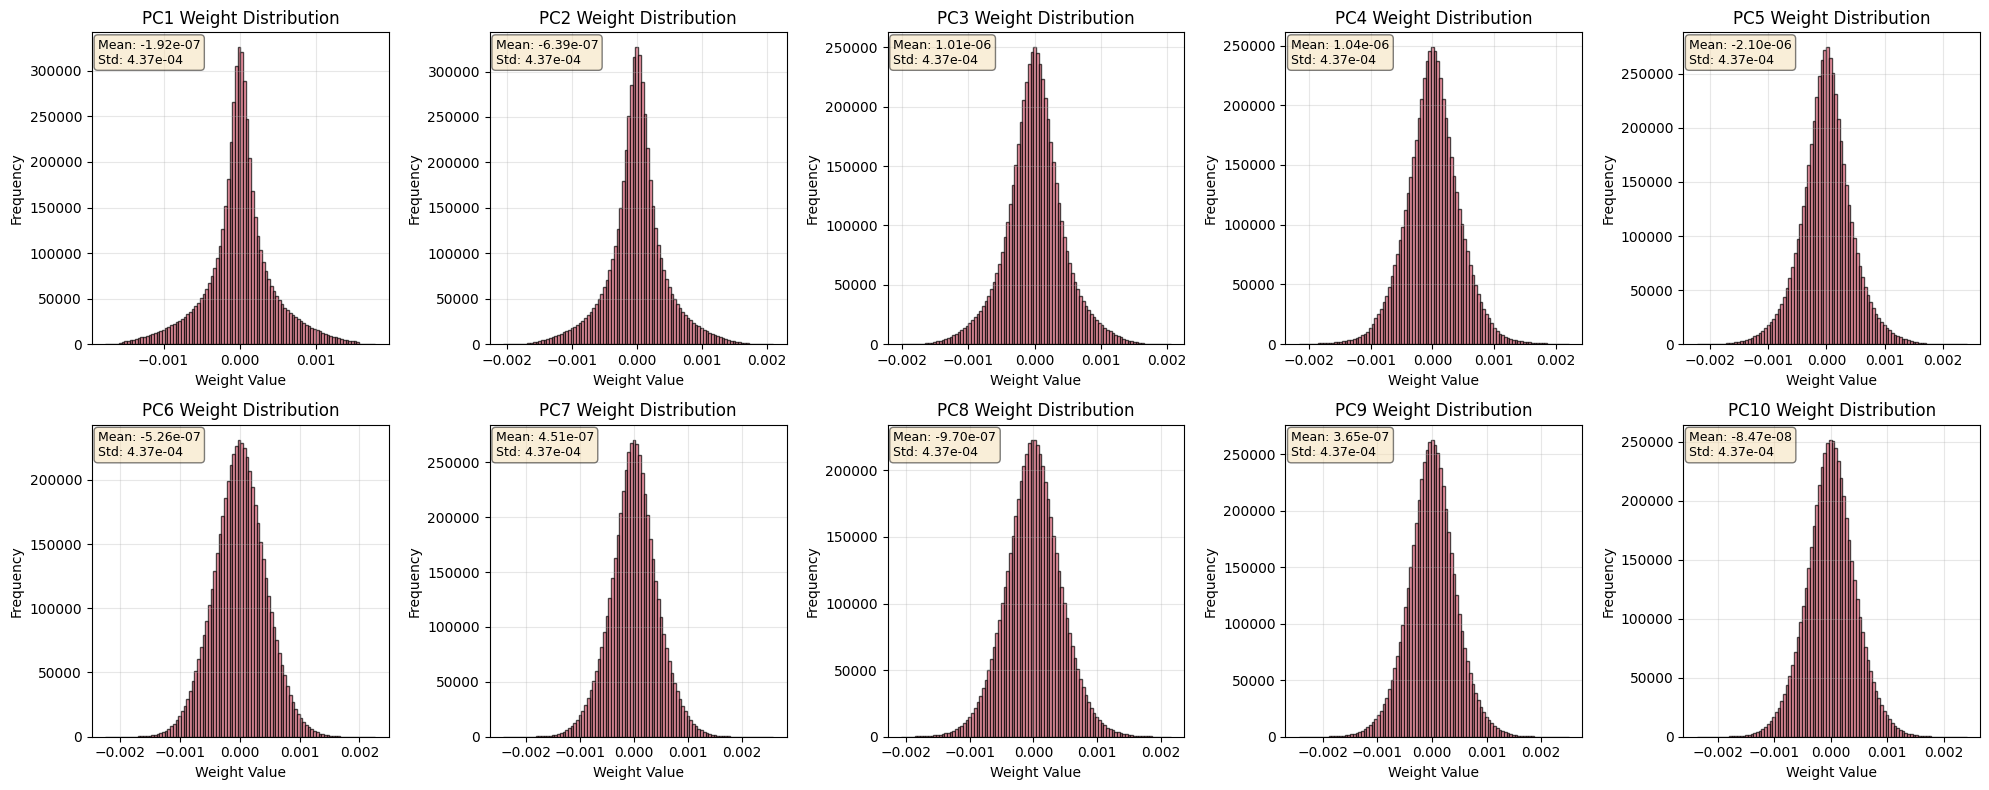

Saved: pc_weight_distributions.png


In [44]:
# Visualization 1: Weight distributions of top 10 PCs
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    weights = pca_components[i]
    
    ax.hist(weights, bins=100, alpha=0.7, edgecolor='black')
    ax.set_title(f'PC{i+1} Weight Distribution', fontsize=12)
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.02, 0.98, f'Mean: {weights.mean():.2e}\nStd: {weights.std():.2e}',
            transform=ax.transAxes, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(pca_dir, 'pc_weight_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Saved: pc_weight_distributions.png")


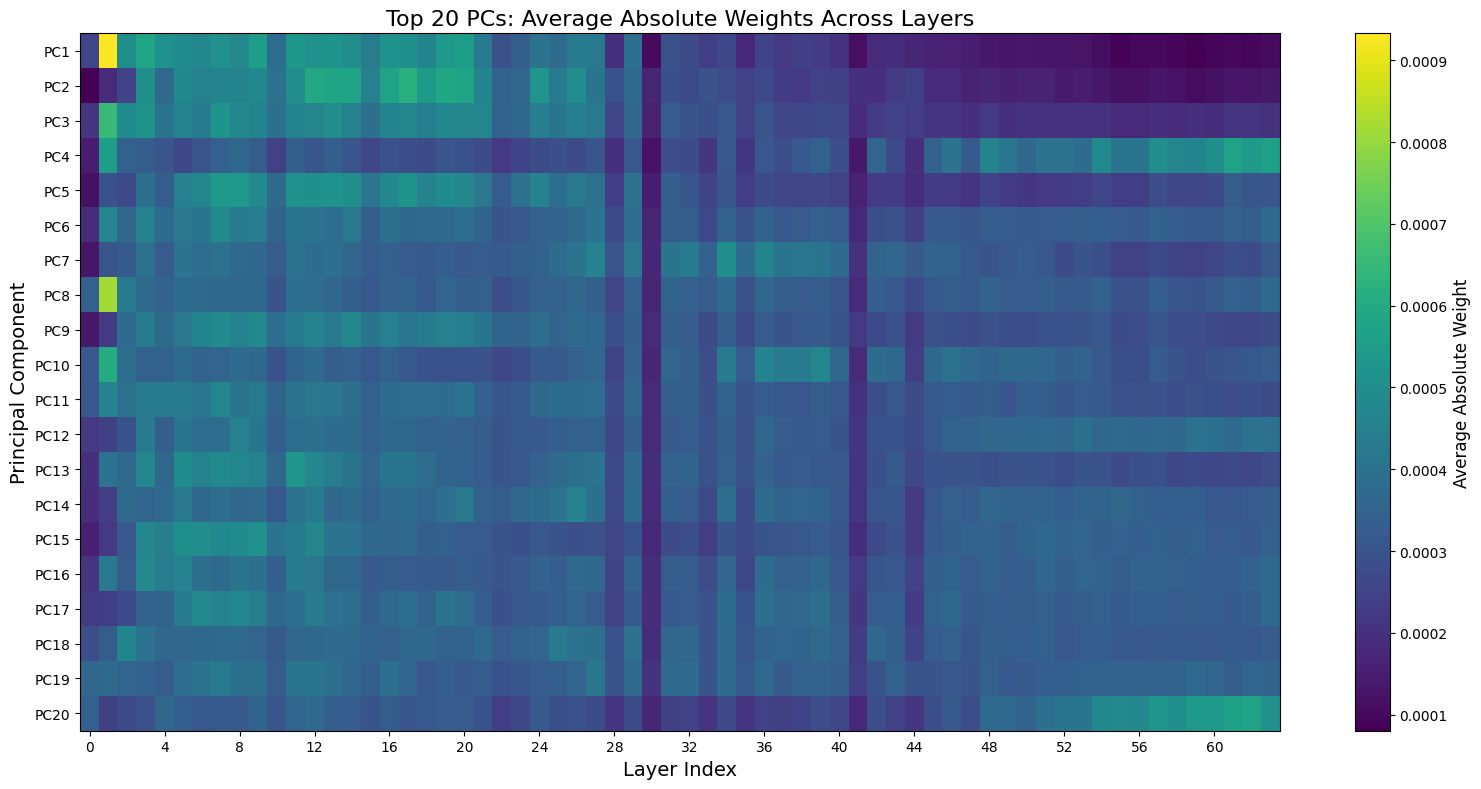

Saved: pc_layer_heatmap.png


In [45]:
# Visualization 2: Average weights of PCs across layers (heatmap)
# Reshape PCs to [n_components, n_layers, d_inner, d_state]
# Then average over d_inner and d_state to get [n_components, n_layers]

n_pcs_to_show = 20
pcs_reshaped = pca_components[:n_pcs_to_show].reshape(n_pcs_to_show, n_layers, d_inner, d_state)

# Calculate average absolute weights per layer
layer_weights = np.abs(pcs_reshaped).mean(axis=(2, 3))  # [n_pcs, n_layers]

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(layer_weights, aspect='auto', cmap='viridis', interpolation='nearest')

ax.set_xlabel('Layer Index', fontsize=14)
ax.set_ylabel('Principal Component', fontsize=14)
ax.set_title(f'Top {n_pcs_to_show} PCs: Average Absolute Weights Across Layers', fontsize=16)

# Set ticks
ax.set_yticks(range(n_pcs_to_show))
ax.set_yticklabels([f'PC{i+1}' for i in range(n_pcs_to_show)])

ax.set_xticks(range(0, n_layers, 4))
ax.set_xticklabels(range(0, n_layers, 4))

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Average Absolute Weight', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(pca_dir, 'pc_layer_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Saved: pc_layer_heatmap.png")


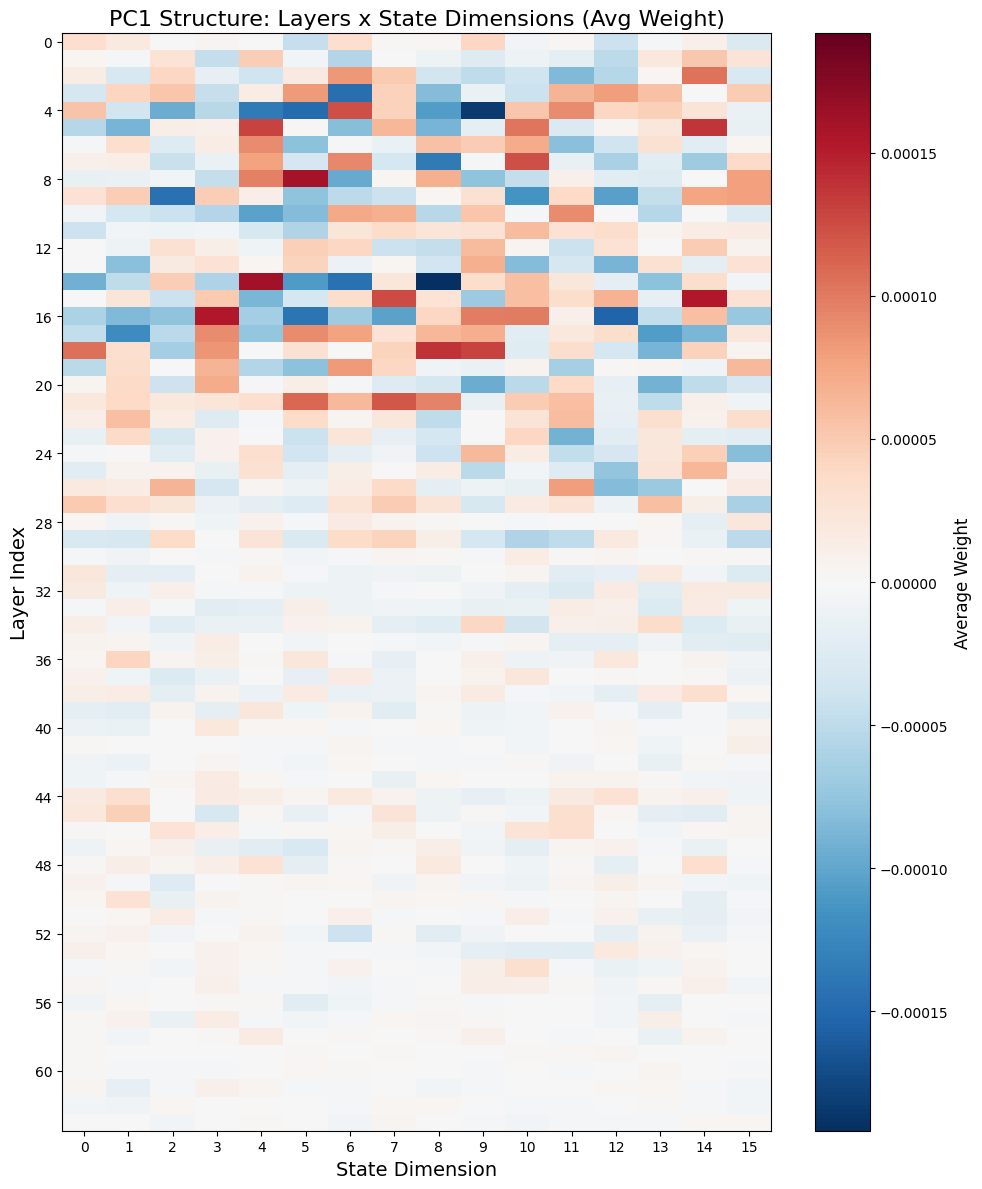

Saved: pc1_structure.png


In [ ]:
# Visualization 3: Detailed structure of a single PC (PC1 example)
# Reshape to [n_layers, d_inner, d_state] and compute L2 norm over d_state
# Get [n_layers, d_inner] heatmap

pc_idx = 0  # Select first principal component
pc = pca_components[pc_idx].reshape(n_layers, d_inner, d_state)

# Compute L2 norm over d_state dimension
pc_layer_inner = np.linalg.norm(pc, axis=2)  # [n_layers, d_inner]

# Plot heatmap
fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(pc_layer_inner, aspect='auto', cmap='viridis', interpolation='nearest')

ax.set_xlabel('d_inner Dimension (5120)', fontsize=14)
ax.set_ylabel('Layer Index', fontsize=14)
ax.set_title(f'PC{pc_idx+1} Structure: Layers x d_inner (L2 Norm over d_state)', fontsize=16)

# Set ticks
ax.set_xticks(range(0, d_inner, 512))
ax.set_xticklabels(range(0, d_inner, 512))
ax.set_yticks(range(0, n_layers, 4))
ax.set_yticklabels(range(0, n_layers, 4))

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('L2 Norm (over d_state)', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(pca_dir, f'pc{pc_idx+1}_structure.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: pc{pc_idx+1}_structure.png")


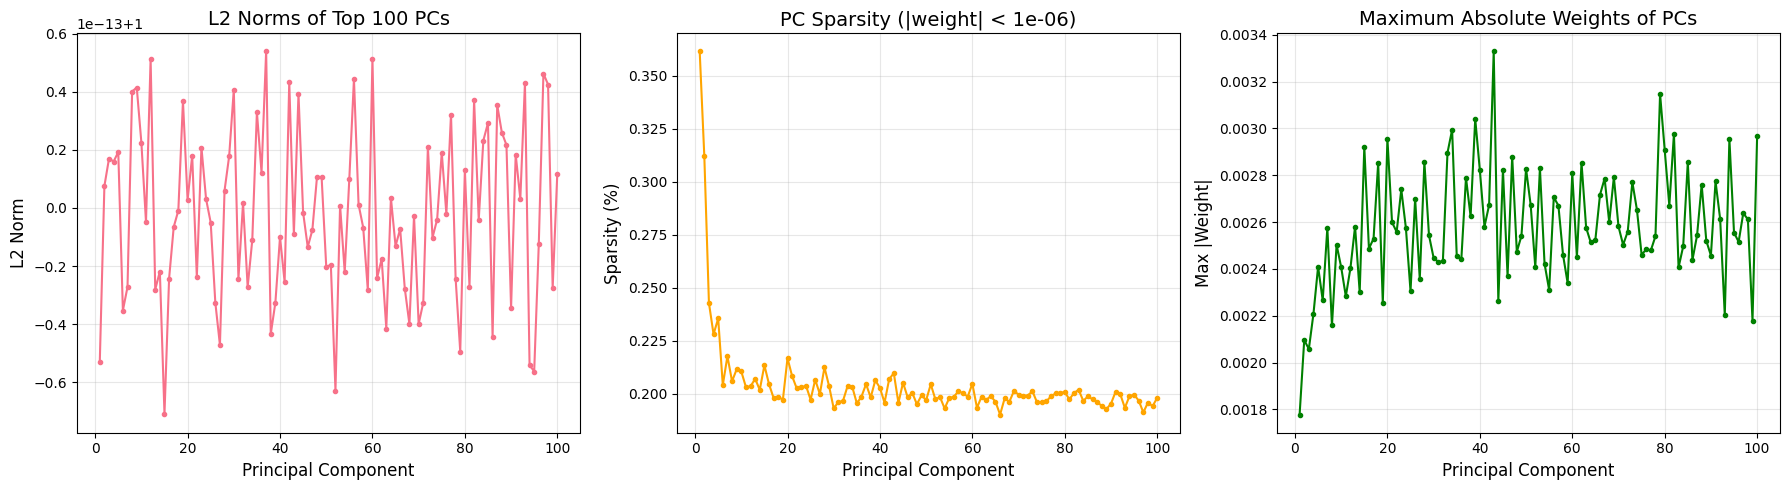

Saved: pc_statistics.png

All visualizations complete! Saved to: experiments/pca_06102323


In [47]:
# Visualization 4: PC norms and sparsity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 4.1 L2 norms
n_pcs = min(100, pca_components.shape[0])
l2_norms = np.linalg.norm(pca_components[:n_pcs], axis=1)

axes[0].plot(range(1, n_pcs+1), l2_norms, marker='o', markersize=3)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('L2 Norm', fontsize=12)
axes[0].set_title(f'L2 Norms of Top {n_pcs} PCs', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 4.2 Sparsity (proportion near zero)
threshold = 1e-6
sparsity = (np.abs(pca_components[:n_pcs]) < threshold).mean(axis=1)

axes[1].plot(range(1, n_pcs+1), sparsity * 100, marker='o', markersize=3, color='orange')
axes[1].set_xlabel('Principal Component', fontsize=12)
axes[1].set_ylabel('Sparsity (%)', fontsize=12)
axes[1].set_title(f'PC Sparsity (|weight| < {threshold})', fontsize=14)
axes[1].grid(True, alpha=0.3)

# 4.3 Maximum absolute weights
max_abs_weights = np.abs(pca_components[:n_pcs]).max(axis=1)

axes[2].plot(range(1, n_pcs+1), max_abs_weights, marker='o', markersize=3, color='green')
axes[2].set_xlabel('Principal Component', fontsize=12)
axes[2].set_ylabel('Max |Weight|', fontsize=12)
axes[2].set_title('Maximum Absolute Weights of PCs', fontsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(pca_dir, 'pc_statistics.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Saved: pc_statistics.png")
print(f"\nAll visualizations complete! Saved to: {pca_dir}")


## Summary

Generated visualization files:

1. **`pc_weight_distributions.png`** - Weight distributions of top 10 PCs (histograms)
2. **`pc_layer_heatmap.png`** - Average weights of top 20 PCs across 64 layers (heatmap)
3. **`pc1_structure.png`** - Detailed structure of PC1: layers × state dimensions
4. **`pc_statistics.png`** - L2 norms, sparsity, and max absolute weights of PCs

These figures show:
- Structure and properties of the PCA transformation matrix
- Which layers and feature dimensions different PCs focus on
- Complexity and sparsity of principal components

Use these insights to understand what the PCA has learned!


## 完成！现在可以使用 `transform_new_data.py` 变换任何新数据


In [48]:
print("✓ 所有参数已准备完成！\\n")
print("使用命令行变换新数据：")
print(f"python PCA_analysis/transform_new_data.py \\\\")
print(f"    --pca_dir {pca_dir} \\\\")
print(f"    --cache_diff_file path/to/new_file.pt \\\\")
print(f"    --flatten_mode {flatten_mode}")


✓ 所有参数已准备完成！\n
使用命令行变换新数据：
python PCA_analysis/transform_new_data.py \\
    --pca_dir experiments/pca_06102323 \\
    --cache_diff_file path/to/new_file.pt \\
    --flatten_mode all
